## 1. Setup and Import libraries

In [1]:
# django path
mysite_path = "C:\\Data\\UCL\\@MSc Project\\DB\\mysite\\"

In [2]:
# standard packages
import os
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import django
from set_django_db import set_django_db
from asgiref.sync import sync_to_async

from IPython.core.display import HTML

%matplotlib inline

In [3]:
# set django models
set_django_db(mysite_path)
from tables_daniel.models import Company, Review

# specifically for Jupyter notebooks
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [4]:
# set pandas display
pd.set_option('display.max_rows', 100)

In [5]:
# center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical_align: middle;
}
</style>
""")

## 2. Filter companies (+reviews) listed on S&P 500

### 2.1 Load the data

#### 2.1.1 Companies

In [6]:
companies = pd.DataFrame(
    list(
        Company
        .objects
        .values('id', 'Company', 'Country', 'Sector', 'Industry', 'NoEmployees', 'Revenue')
        .all()
        .filter(ListedOn='S&P 500')
    )
)

In [7]:
companies['TotalReviews'] = 0

def sumReviews(row):
    try:
        return len(
            list(
                Review
                .objects
                .all()
                .filter(Company=companies.loc[row, 'id'])
            )
        )
    except:
        return 0


for row in range(companies.shape[0]):
    companies.loc[row, 'TotalReviews'] = sumReviews(row)

In [8]:
companies

,id,Company,Country,Sector,Industry,NoEmployees,Revenue,TotalReviews
0,51,3M Company,3M Center,Industrials,Specialty Industrial Machinery,96163,32348000.0,0
1,52,Abbott Laboratories,United States,Healthcare,Medical Devices,107000,32095000.0,830
2,53,AbbVie Inc.,United States,Healthcare,Drug Manufacturers—General,30000,34057000.0,300
3,54,ABIOMED Inc,United States,Healthcare,Medical Devices,1536,840883.0,60
4,55,Accenture plc,Grand Canal Harbour,Technology,Information Technology Services,513000,43274244.0,1040
...,...,...,...,...,...,...,...,...
495,546,Yum! Brands Inc,United States,Consumer Cyclical,Restaurants,34000,5606000.0,0
496,547,Zebra Technologies,United States,Technology,Communication Equipment,8200,4471000.0,0
497,548,Zimmer Biomet Holdings,United States,Healthcare,Medical Devices,19900,7790500.0,0
498,549,Zions Bancorp,One South Main Street,Financial Services,Banks—Regional,9879,2808000.0,0


#### 2.1.2 Reviews

In [9]:
companies_id = list(companies.id)

In [10]:
reviews = list(
    Review
    .objects
    .values('Company_id', 'ReviewTitle', 'Rating', 'Pros', 'Cons', 'Year', 'Month', 'Day',
            'JobTitle', 'EmployeeRelationship')
    .all()
    .filter(Company_id = company_id) for company_id in companies_id
)

In [11]:
reviews_df = pd.DataFrame(
    sum([list(reviews_i) for reviews_i in reviews],[])
)

print(reviews_df.shape)


#########
reviews_df = reviews_df.drop_duplicates()
print(reviews_df.shape)

(169045, 10)
(168596, 10)


In [12]:
reviews_df.head()

,Company_id,ReviewTitle,Rating,Pros,Cons,Year,Month,Day,JobTitle,EmployeeRelationship
0,52,Fullfilling work,5.0,There are loads of opportunities to grow!,Can be boring / monotonous.,2020,7,9,Former Employee,Machine Operator
1,52,Great Benefits and Opportunities,5.0,The 2 best things about the company are all th...,Communication can be poor at times and the int...,2020,7,6,Current Employee,Process Associate
2,52,review,3.0,helpful colleagues good work environment,limited exposure at the firm,2020,7,6,Current Employee,RMA
3,52,Not okay place to work after a while,1.0,Pay and benefits and some culture inclusive ev...,"Poor engineering design, process, and procedur...",2020,7,5,Former Employee,Systems Engineer
4,52,Great workplace,5.0,"flexible schedule, work from home can be arran...",expensive cafeteria and not to many options on...,2020,7,4,Current Employee,Process Development Engineer


### 2.2 DF transformation

Add some useful columns

In [13]:
reviews_df = reviews_df.merge(
    companies[['id', 'Company', 'Sector']].rename(columns={'id': 'Company_id',
                                                           'Company': 'Company',
                                                           'Sector': 'Sector'                                                 
                                                }),
    on='Company_id'
)

In [14]:
reviews_df['Date'] = reviews_df.apply(lambda x: '-'.join(
    [str(x['Year']), str(x['Month']), str(x['Day'])]
    ), axis=1
)

reviews_df

,Company_id,ReviewTitle,Rating,Pros,Cons,Year,Month,Day,JobTitle,EmployeeRelationship,Company,Sector,Date
0,52,Fullfilling work,5.0,There are loads of opportunities to grow!,Can be boring / monotonous.,2020,7,9,Former Employee,Machine Operator,Abbott Laboratories,Healthcare,2020-7-9
1,52,Great Benefits and Opportunities,5.0,The 2 best things about the company are all th...,Communication can be poor at times and the int...,2020,7,6,Current Employee,Process Associate,Abbott Laboratories,Healthcare,2020-7-6
2,52,review,3.0,helpful colleagues good work environment,limited exposure at the firm,2020,7,6,Current Employee,RMA,Abbott Laboratories,Healthcare,2020-7-6
3,52,Not okay place to work after a while,1.0,Pay and benefits and some culture inclusive ev...,"Poor engineering design, process, and procedur...",2020,7,5,Former Employee,Systems Engineer,Abbott Laboratories,Healthcare,2020-7-5
4,52,Great workplace,5.0,"flexible schedule, work from home can be arran...",expensive cafeteria and not to many options on...,2020,7,4,Current Employee,Process Development Engineer,Abbott Laboratories,Healthcare,2020-7-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168591,534,Work,3.0,We have new technology of flash memory and SSD.,Company strategy is weak until 5years later.,2018,6,9,Anonymous Employee,Current Employee,Western Digital,Technology,2018-6-9
168592,534,Manager,4.0,"Great benefits, work-life balance, training op...","Instability, uncertainty in future due to no t...",2018,6,9,Manager,Former Employee,Western Digital,Technology,2018-6-9
168593,534,Great workplace,5.0,Good pay and benefits. Great technology.,"Hectic schedule, worklife balance is not great",2018,6,7,Anonymous Employee,Former Employee,Western Digital,Technology,2018-6-7
168594,534,being a software lead in a hardware company ha...,3.0,"good people, fair benefits, good location",management is not concern with success of the ...,2018,6,20,Software Developer,Former Employee,Western Digital,Technology,2018-6-20


In [15]:
def string_to_date(date_str):
    try:
        return datetime.strptime(date_str, '%Y-%m-%d')
    except:
        return datetime.strptime('1800-1-1', '%Y-%m-%d')
    
def string_to_YM(date_str):
    try:
        return datetime.strptime(date_str, '%Y-%m')
    except:
        return datetime.strptime('1800-1-1', '%Y-%m-%d')

reviews_df['Date'] = reviews_df['Date'].apply(lambda x: string_to_date(x))

reviews_df['Year-Month'] = reviews_df.apply(lambda x: string_to_YM('-'.join([str(x['Year']), str(x['Month'])])), axis=1)

In [16]:
reviews_df

,Company_id,ReviewTitle,Rating,Pros,Cons,Year,Month,Day,JobTitle,EmployeeRelationship,Company,Sector,Date,Year-Month
0,52,Fullfilling work,5.0,There are loads of opportunities to grow!,Can be boring / monotonous.,2020,7,9,Former Employee,Machine Operator,Abbott Laboratories,Healthcare,2020-07-09,2020-07-01
1,52,Great Benefits and Opportunities,5.0,The 2 best things about the company are all th...,Communication can be poor at times and the int...,2020,7,6,Current Employee,Process Associate,Abbott Laboratories,Healthcare,2020-07-06,2020-07-01
2,52,review,3.0,helpful colleagues good work environment,limited exposure at the firm,2020,7,6,Current Employee,RMA,Abbott Laboratories,Healthcare,2020-07-06,2020-07-01
3,52,Not okay place to work after a while,1.0,Pay and benefits and some culture inclusive ev...,"Poor engineering design, process, and procedur...",2020,7,5,Former Employee,Systems Engineer,Abbott Laboratories,Healthcare,2020-07-05,2020-07-01
4,52,Great workplace,5.0,"flexible schedule, work from home can be arran...",expensive cafeteria and not to many options on...,2020,7,4,Current Employee,Process Development Engineer,Abbott Laboratories,Healthcare,2020-07-04,2020-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168591,534,Work,3.0,We have new technology of flash memory and SSD.,Company strategy is weak until 5years later.,2018,6,9,Anonymous Employee,Current Employee,Western Digital,Technology,2018-06-09,2018-06-01
168592,534,Manager,4.0,"Great benefits, work-life balance, training op...","Instability, uncertainty in future due to no t...",2018,6,9,Manager,Former Employee,Western Digital,Technology,2018-06-09,2018-06-01
168593,534,Great workplace,5.0,Good pay and benefits. Great technology.,"Hectic schedule, worklife balance is not great",2018,6,7,Anonymous Employee,Former Employee,Western Digital,Technology,2018-06-07,2018-06-01
168594,534,being a software lead in a hardware company ha...,3.0,"good people, fair benefits, good location",management is not concern with success of the ...,2018,6,20,Software Developer,Former Employee,Western Digital,Technology,2018-06-20,2018-06-01


## 3. Company exploration

### 3.1 Companies and reviews per sector

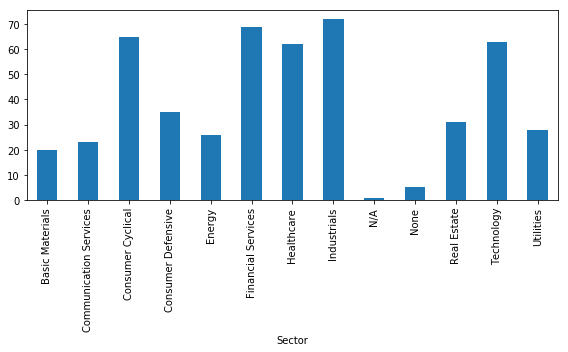

In [17]:
plt.figure(figsize=(8,5))

(companies
 .groupby('Sector')
 .count()
 .id
 .plot
 .bar()
)

#plt.ylim(top)

plt.tight_layout()

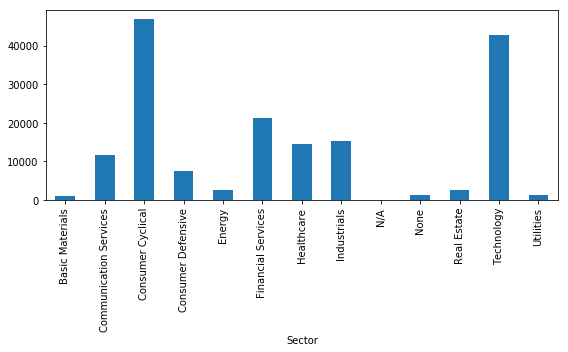

In [18]:
plt.figure(figsize=(8,5))

(reviews_df
 .groupby('Sector')
 .count()
 .Company_id
 .plot
 .bar()
)

plt.tight_layout()

### 3.2 Companies per industry

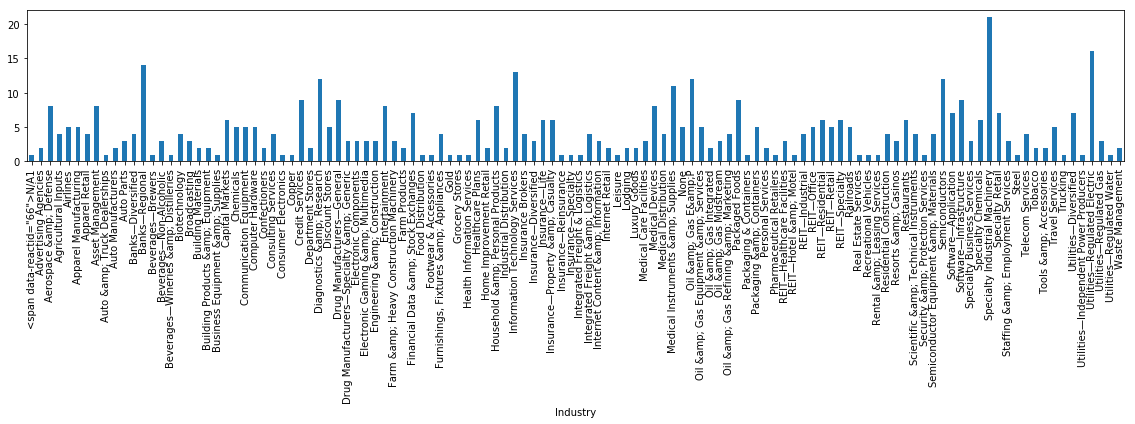

In [20]:
plt.figure(figsize=(16,6))

(companies
 .groupby('Industry')
 .count()
 .id
 .plot
 .bar()
)

plt.ylim

plt.tight_layout()

## 4. Review/ratings exploration

In [21]:
min_date = datetime.strptime('2018-7-1', '%Y-%m-%d')
max_date = datetime.strptime('2020-6-30', '%Y-%m-%d')

### 4.1 Mean rating - per month & sector

In [22]:
reviews_MonthSector = pd.DataFrame(reviews_df[(reviews_df.Date >= min_date) & (reviews_df.Date <= max_date)]
 .groupby(['Sector', 'Year-Month'])
 .agg(['count', 'mean'])
)

reviews_MonthSector = pd.DataFrame(
    reviews_MonthSector.to_records()
)[['Sector', 'Year-Month', "('Rating', 'mean')", "('Rating', 'count')"]]

reviews_MonthSector.columns = ['Sector', 'Year-Month', 'Rating', 'Count']

In [23]:
sectors = reviews_MonthSector.Sector.unique()

reviews_MonthSector

,Sector,Year-Month,Rating,Count
0,Basic Materials,2018-07-01,3.979167,48
1,Basic Materials,2018-08-01,3.681818,44
2,Basic Materials,2018-09-01,4.088235,34
3,Basic Materials,2018-10-01,3.900000,30
4,Basic Materials,2018-11-01,3.552632,38
...,...,...,...,...
307,Utilities,2020-02-01,3.642857,56
308,Utilities,2020-03-01,3.820000,50
309,Utilities,2020-04-01,4.344828,29
310,Utilities,2020-05-01,3.636364,44


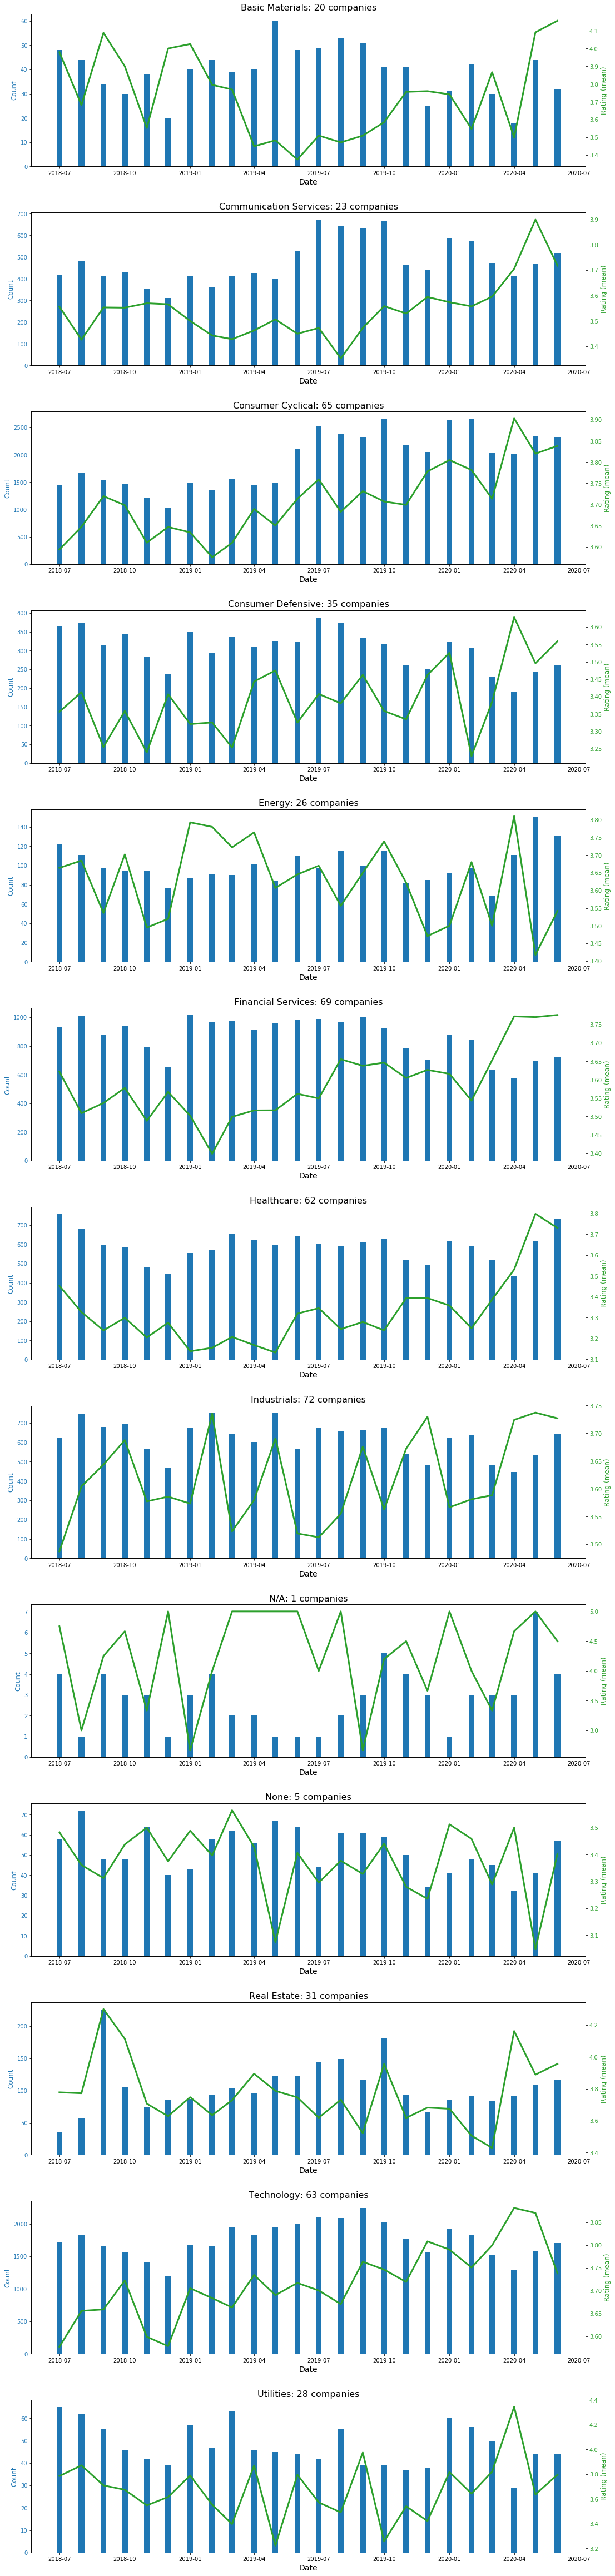

In [24]:
fig, axes = plt.subplots(len(sectors),1, figsize = (16,5*len(sectors) ))

for i, sector in enumerate(sectors):
    no_companies = companies[companies.Sector == sector].shape[0]
    
    axes[i].set_xlabel('Date', fontsize=14)
    axes[i].set_title(f'{sector}: {no_companies} companies', fontsize=16)

    color = 'tab:blue'
    axes[i].set_ylabel('Count', color=color, fontsize=12)  # we already handled the x-label with ax1
    axes[i].bar(
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['Year-Month'],
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['Count'],
        color=color,
        width=8
    )
    axes[i].tick_params(axis='y', labelcolor=color)

    ax2 = axes[i].twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:green'

    ax2.set_ylabel('Rating (mean)', color=color, fontsize=12)
    ax2.plot(
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['Year-Month'],
        reviews_MonthSector[reviews_MonthSector.Sector == sector]['Rating'],
        color=color,
        linewidth=3
    )
    ax2.tick_params(axis='y', labelcolor=color)

plt.tight_layout(pad=3.0)